
**Baseline Machine Learning models** to predict customer churn using the cleaned dataset 
We’ll:
1. Split the dataset into train/test sets.  
2. Train multiple baseline models (Logistic Regression, Random Forest, XGBoost).  
3. Evaluate them on metrics such as Accuracy, F1-Score, Recall, and ROC-AUC.  
4. Identify which model performs best for further tuning.


###  Data Loading and Setup
Loading the cleaned dataset savedand defining our features and target variable.


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load cleaned dataset
df = pd.read_csv('../data/cleaned_churn_data.csv')

# Define features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### 🔹 Training Baseline Models
Train three common classification models:
- Logistic Regression (interpretable linear baseline)
- Random Forest Classifier (non-linear ensemble)
- XGBoost Classifier (gradient-boosted trees)


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}


c:\Users\fff\.vscode\Cust_Churn\Customer-Churn-Prediction\venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


### 🔹 Evaluation Metrics
Evaluate each model using:
- **Accuracy:** overall correctness  
- **Precision & Recall:** balance of false positives/negatives  
- **F1-Score:** harmonic mean of precision & recall  
- **ROC-AUC:** ranking quality for imbalanced data


In [3]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-Score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_prob)
    })

results_df = pd.DataFrame(results).sort_values(by="ROC-AUC", ascending=False)
results_df


# Identify the best model based on ROC-AUC
best_model_name = results_df.iloc[0]["Model"]
best_model = models[best_model_name]

print(f"Best Model Selected: {best_model_name}")






c:\Users\fff\.vscode\Cust_Churn\Customer-Churn-Prediction\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Best Model Selected: Logistic Regression


### Model Performance Summary
Compare the models to determine the strongest baseline.


In [ ]:
# ---------------------------------------------------------------
# Save Final Model and Metadata
# ---------------------------------------------------------------
import joblib, os

# Ensure the model directory exists
os.makedirs("../model", exist_ok=True)

# Save the best trained model directly
joblib.dump(best_model, "../model/churn_model.pkl")
print(f"✅ Final model '{best_model_name}' saved successfully as churn_model.pkl")

# Save the feature columns from df_encoded (for Streamlit app)
joblib.dump(X_train.columns.tolist(), "../model/feature_columns.pkl")
print("✅ Feature column names saved for inference!")

# Optional: also save as baseline (for versioning)
joblib.dump(best_model, "../model/logistic_regression_baseline.pkl")
print("✅ Baseline model also saved.")


✅ Final model 'Logistic Regression' saved successfully as churn_model.pkl
✅ Feature column names saved for inference!
✅ Baseline model also saved.


C:\Users\fff\AppData\Local\Temp\ipykernel_6560\1305566684.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="coolwarm")


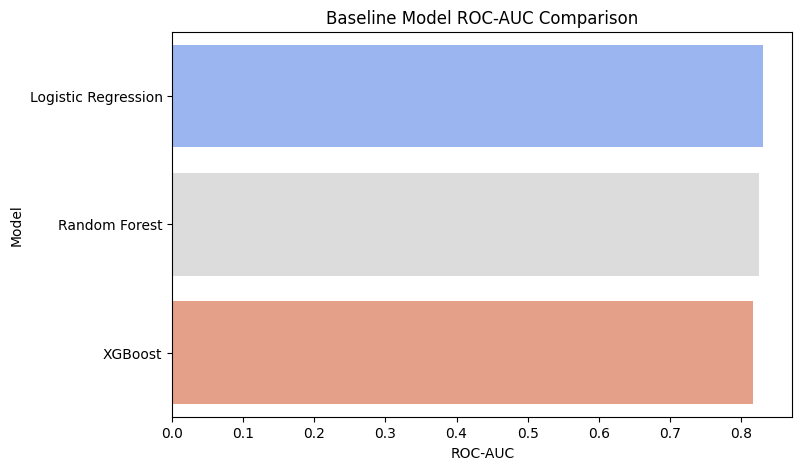

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.barplot(x="ROC-AUC", y="Model", data=results_df, palette="coolwarm")
plt.title("Baseline Model ROC-AUC Comparison")
plt.show()


**Observation:**  
- The model with the highest ROC-AUC will be our baseline for further tuning   
- Typically, XGBoost or Random Forest outperform Logistic Regression on non-linear data.


In [ ]:

import os
print(os.getcwd())
os.listdir("../model")


c:\Users\fff\.vscode\Cust_Churn\Customer-Churn-Prediction\notebooks


['churn_model.pkl', 'feature_columns.pkl', 'logistic_regression_baseline.pkl']

### 🔹 Model Explainability Preview
- Use **SHAP (SHapley Additive Explanations)** to identify the most influential features driving churn.  
- This helps business teams understand *why* the model predicts a customer will churn.


###  SHAP Explainability for XGBoost (Patched Version)

Due to compatibility issues in XGBoost ≥ 2.0, we apply a small patch that converts 
the model’s internal `base_score` from string to float. 

This allows SHAP’s `TreeExplainer` to run successfully and compute feature importance.

The SHAP summary plot below shows the top features influencing customer churn, 
providing interpretability for our model’s decisions.


IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


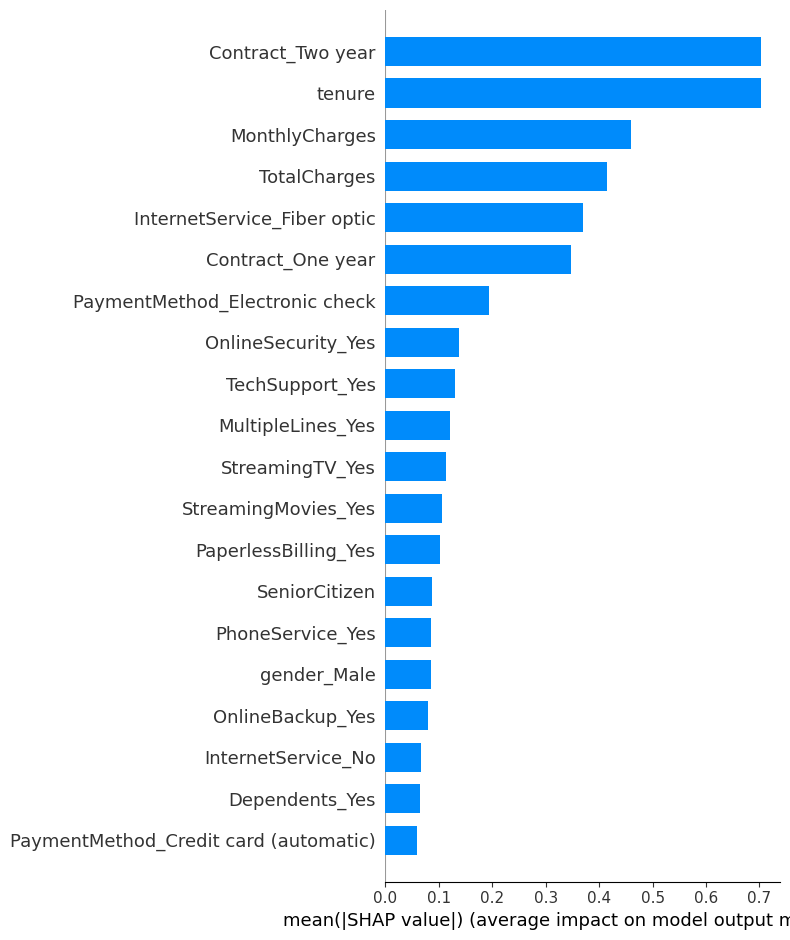

In [ ]:
import shap

# Get the trained booster
booster = models["XGBoost"].get_booster()

#  Patch for XGBoost ≥2.0: convert base_score string → float
if isinstance(booster.attr("base_score"), str):
    base_score_str = booster.attr("base_score").strip("[]")
    booster.set_attr(base_score=float(base_score_str))

# Create TreeExplainer and compute SHAP values
explainer = shap.TreeExplainer(booster)
shap_values = explainer.shap_values(X_test)

# Plot feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")


### Summary

- Loaded and prepared the cleaned dataset.  
- Trained three baseline models: Logistic Regression, Random Forest, and XGBoost.  
- Evaluated all models using Accuracy, Recall, F1, and ROC-AUC.  
- Selected the best baseline (highest ROC-AUC).  
- Set up SHAP explainability for the next phase.  
- Saved the baseline model for future tuning and deployment.
